# 19 - Evaluating Causal Models

In the vast majority of material about causality, researchers use synthetic data to check if their methods are any good. Much like we did in the When Prediction Fails chapter, they generate data on both $Y_{0i}$ and $Y_{1i}$ so that they can check if their model is correctly capturing the treatment effect $Y_{1i} - Y_{0i}$. That's fine for academic purposes, but in the real world, we don't have that luxury. When applying these techniques in the industry, we'll be asked time and again to prove why our model is better, why should it replace the current one in production or why it won't fail miserably. This is so crucial that it's beyond my comprehension why we don't see any material whatsoever explaining how we should evaluate causal inference models with real data. 

As a consequence, data scientists that want to apply causal inference models have a really hard time convincing management to trust them. The approach they take is one of showing how sound the theory is and how careful they've been while training the model. Unfortunately, in a world where train-test split paradigm is the norm, that just won't cut it. __The quality of your model will have to be grounded on something more concrete than a beautiful theory__. Think about it. Machine learning has only achieved its huge success because predictive model validation is very straightforward. There is something reassuring about seeing that the predictions match what really happened. 

Unfortunately, it isn't obvious at all how we achieve anything like a train-test paradigm in the case of causal inference. That's because causal inference is interested in estimating an __unobservable quantity__, $\frac{\delta y}{ \delta t}$. Well, if we can't see it, how the hell are we supposed to know if our models are any good at estimating it? Remember, it is as if every entity had an underlying responsiveness, denoted by the slope of the line from treatment to outcome, but we can't measure it.

![img](./data/img/evaluate-causal-models/sneak.png)

This is a very very very hard thing to wrap our heads around and it took me years to find something close to an answer. Is not a definitive one, but it works in practice and it has that concreteness, which I hope will approach causal inference from a train-test paradigm similar to the one we have with machine learning. 

The trick is to use __aggregate measurements of sensitivity__. Even if you can't estimate sensitivity individually, you can do it for a group and that is what we will leverage here.

In [9]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from toolz import curry

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings("ignore")

In this chapter, we'll __use non random data to estimate our causal models and random data to evaluate it__. 

Again, we will be talking about how price impacts ice cream sales. As we'll see, __random data is very valuable for evaluation purposes__. However, in real life, it is often expensive to collect random data (why would you set prices at random if you know some of them are not very good ones and will only make you lose money???). What ends up happening is that we often have an abundance of data where the treatment is **NOT** random and very few, if any, random data. Since evaluating a model with non random data is incredibly tricky, __if we have any random data, we  tend to leave that for evaluation purposes__. 

And just in case you forgot, here is what the data looks like.

In [11]:
prices = pd.read_csv("./data/ice_cream_sales.csv") # loads non-random data
print(prices.head())
print(prices.shape)

   temp  weekday  cost  price  sales
0  17.3        6   1.5    5.6    173
1  25.4        3   0.3    4.9    196
2  23.3        5   1.5    7.6    207
3  26.9        1   0.3    5.3    241
4  20.2        1   1.0    7.2    227
(10000, 5)


<AxesSubplot:xlabel='price', ylabel='sales'>

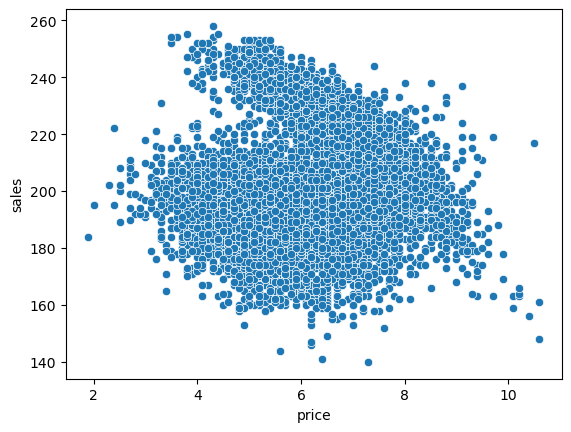

In [16]:
sns.scatterplot(data = prices, x = 'price', y = 'sales')

In [12]:
prices_rnd = pd.read_csv("./data/ice_cream_sales_rnd.csv") # loads random data
print(prices_rnd.head())
print(prices_rnd.shape)

   temp  weekday  cost  price  sales
0  25.8        1   0.3      7    230
1  22.7        3   0.5      4    190
2  33.7        7   1.0      5    237
3  23.0        4   0.5      5    193
4  24.4        1   1.0      3    252
(5000, 5)


<AxesSubplot:xlabel='price', ylabel='sales'>

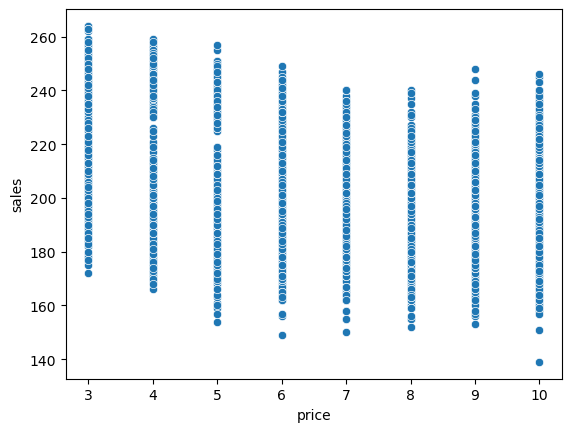

In [17]:
sns.scatterplot(data = prices_rnd, x = 'price', y = 'sales')

To have something to compare, let's train two models. The first one will be a linear regression with interactions terms so that sensitivity is allowed to vary between units. 

$$
sales_i = \beta_0 + \beta_1 price_i + \pmb{\beta_2 X}_i + \pmb{\beta_3 X}_i price_i + e_i
$$

Once we fit this model, we will be able to make sensitivity predictions

$$
\widehat{\frac{\delta sales}{ \delta price}} = \hat{\beta_1} + \pmb{\hat{\beta_3} X}_i
$$

In [13]:
m1 = smf.ols("sales ~ price*cost + price*C(weekday) + price*temp", data=prices).fit()

The second model will be fully nonparametric, machine learning, predictive model

$$
sales_i = G(X_i, price_i) + e_i
$$

In [14]:
X = ["temp", "weekday", "cost", "price"]
y = "sales"

np.random.seed(1)
m2 = GradientBoostingRegressor()
m2.fit(prices[X], prices[y]);

Just to make sure the model is not heavily overfitting, we can check the $R^2$ on the data we've used to train it and on the new, unseen data. (For those more versed in Machine Learning, notice that some drop in performance is expected, because there is a __concept drift__. The model was trained in data where price is not random, but the test set has only randomized prices).

In [15]:
print("Train Score:", m2.score(prices[X], prices[y]))
print("Test Score:", m2.score(prices_rnd[X], prices_rnd[y]))

Train Score: 0.9251704824568053
Test Score: 0.7711074163447711


After training our models, we will get the sensitivity from the regression model. Again, we will resort to a __numerical approximation__.

$$
\frac{\delta y(t)}{\delta t} \approx  \frac{y(t+h) - y(t)}{h}
$$

Our models were trained on non-random data. __Now we turn to the random data to make predictions__. Just so we have everything in one place, we will add the predictions from the machine learning model and the sensitivity prediction from the causal model in a single dataframe, `prices_rnd_pred`.

Moreover, let's also include a __random model__. The idea is that this model just outputs random numbers as predictions. It is obviously not very useful, but it shall serve well as a __benchmark__. Whenever we are talking about new ways of making evaluations, I always like to think about how a random (useless) model would do. If the random model is able to perform well on the evaluation criterion, that says something about how good the evaluation method really is. 

In [18]:
def predict_sensitivity(model, price_df, h=0.01):
    return (model.predict(price_df.assign(price=price_df["price"]+h))
            - model.predict(price_df)) / h

np.random.seed(123)
prices_rnd_pred = prices_rnd.assign(**{
    "sensitivity_m_pred": predict_sensitivity(m1, prices_rnd), ## sensitivity model
    "pred_m_pred": m2.predict(prices_rnd[X]), ## predictive model
    "rand_m_pred": np.random.uniform(size=prices_rnd.shape[0]), ## random model
})

prices_rnd_pred.head()

,temp,weekday,cost,price,sales,sensitivity_m_pred,pred_m_pred,rand_m_pred
0,25.8,1,0.3,7,230,-13.096964,224.067406,0.696469
1,22.7,3,0.5,4,190,1.054695,189.889147,0.286139
2,33.7,7,1.0,5,237,-17.362642,237.255157,0.226851
3,23.0,4,0.5,5,193,0.564985,186.688619,0.551315
4,24.4,1,1.0,3,252,-13.717946,250.342203,0.719469


In [62]:
prices_rnd.shape

(5000, 5)

## Sensitivity by Model Band

Now that we have our predictions, we need to evaluate how good they are. And remember, __we can't observe sensitivity, so there isn't a simple ground truth we can compare against__. Instead, let's think back to what we want from our sensitivity models. Perhaps that will give us some insights into how we should evaluate them. 

The idea of making treatment sensitivity models came from the necessity of finding which units are more sensitive to the treatment and which are less. It came from a desire for __personalisation__. 
- Maybe a marketing campaign is very effective in only one segment of the population. 
- Maybe discounts only work for some type of customers. 

A good causal model should help us __find which customers will respond better and worse to a proposed treatment__. 
- They should be able to separate units into how __elastic or sensitive__ they are to the treatment. 
- In our ice cream example, the model should be able to figure out in which days are people willing to spend more on ice cream or, in which days is the price sensitivity less negative. 

If that is the goal, it would be very useful if we could somehow __order units from more sensitive to less sensitive__. 
- Since we have the predicted sensitivity, we can order the units by that prediction and hope it also orders them by the real sensitivity. 

Sadly, we can't evaluate that ordering on a unit level. But, what if we don't need to? What if, instead, we evaluate groups defined by the ordering? If our treatment is randomly distributed (and here is where randomness enters), estimating sensitivity for a group of units is easy. All we need is to compare the outcome between the treated and untreated.

To understand this better, it's useful to picture the binary treatment case. Let's keep the pricing example, but now the treatment is a discount. In other words, prices can be either high (untreated) or low (treated). Let's plot sales on the Y axis, each of our models in the X axis and price as the color. Then, we can split the data on the model axis into three equal sized groups. **If the treatment was randomly assigned**, we can easily estimate the ATE for each group $E[Y|T=1] - E[Y|T=0]
$.

![img](./data/img/evaluate-causal-models/ate_bins.png)

In the image, we can see that:
- The first model is somewhat good at predicting sales (high correlation with sales), but the groups it produces have roughly __the same treatment effect__, as shown in the plot on the bottom. Two of the three segments have the same sensitivity and only the last one has a different, lower sensitivity.
- On the other hand, each group produced by the second model has a different causal effect. That's a sign this model can indeed be useful for personalisation. 
- Finally, the random model produces groups with the exact same sensitivity. That's not very useful, but it's expected. If the model is random, each segment it produces will be a random and representative sample of the data. So the sensitivity in its groups should be roughly the same as the ATE on the entire dataset.

Just by looking at these plots, you can get a feeling of which model is better. The more ordered the sensitivities look like and the more different they are between bands, the better. Here, model 2 is probably better than model 1, which is probably better than the random model.

To generalize this to the continuous case, we can estimate the sensitivity using a single variable linear regression model. 

$$
y_i = \beta_0 + \beta_1t_i + e_i
$$

If we run that model with the sample from a group, we will be __estimating the sensitivity inside that group__. 

From the theory on simple linear regression, we know that

$$
\hat{\beta_1}=\dfrac{\sum (t_i - \bar{t}) (y_i - \bar{y})}{\sum(t_i - \bar{t})^2}
$$

where $\bar{t}$ is the sample average for the treatment and $\bar{y}$ is the sample average for the outcome. Here is what that looks like in code

In [7]:
@curry
def sensitivity(data, y, t):
        # line coeficient for the one variable linear regression 
        return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /
                np.sum((data[t] - data[t].mean())**2))

Let's now apply this to our ice cream price data. For that, we also need a function that segments the dataset into partitions of equal size and applies the sensitivity to each partition. The following code should handle that.

In [8]:
def sensitivity_by_band(df, pred, y, t, bands=10):
    return (df
            .assign(**{f"{pred}_band":pd.qcut(df[pred], q=bands)}) # makes quantile partitions
            .groupby(f"{pred}_band")
            .apply(sensitivity(y=y, t=t))) # estimate the sensitivity on each partition

In [31]:
sensitivity_by_band(prices_rnd_pred, 'sensitivity_m_pred', 'sales', 'price')

sensitivity_m_pred_band
(-18.778000000000002, -14.073]   -11.747670
(-14.073, -12.538]                -9.849720
(-12.538, -4.218]                 -7.872637
(-4.218, -1.941]                   2.163387
(-1.941, -1.103]                   1.284304
(-1.103, -0.421]                   0.528792
(-0.421, 0.217]                    0.269761
(0.217, 0.898]                    -0.289010
(0.898, 1.693]                    -0.666963
(1.693, 5.565]                    -1.958290
dtype: float64

Finally, let's plot the sensitivity by band using the predictions we've made before. Here, we will use each model to construct partitions and then estimate the sensitivity on each partition. 

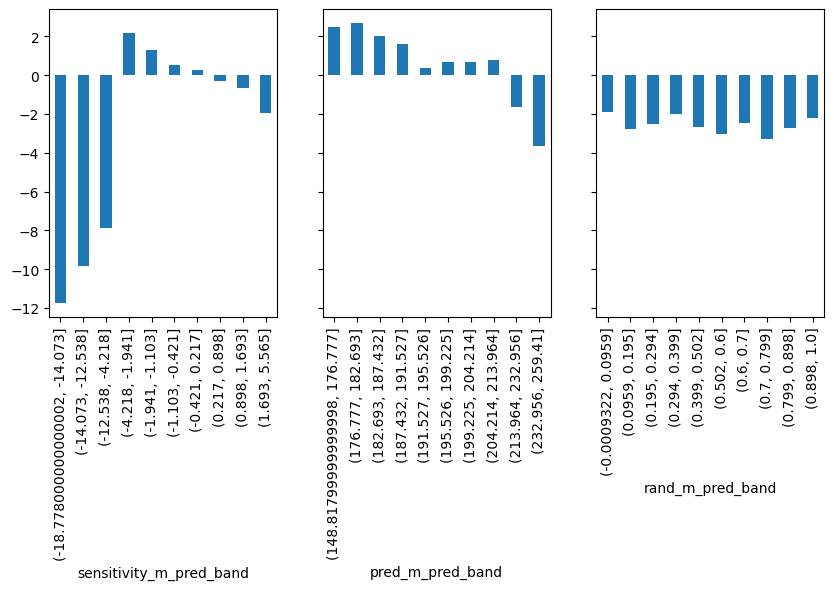

In [19]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(10, 4))
for m, ax in zip(["sensitivity_m_pred", "pred_m_pred", "rand_m_pred"], axs):
    sensitivity_by_band(prices_rnd_pred, m, "sales", "price").plot.bar(ax=ax)


First, look at the random model (`rand_m`). It has roughly the same estimated sensitivity in each of its partitions. We can already see just by looking at the plot that it won't help us much with personalisation since it can't distinguish between the high and low price sensitivity days. 

Next, consider the predictive model, `pred_m`. That model is actually promising! It manages to construct groups where the sensitivity is high and others where the sensitivity is low. That's exactly what we need. 

Finally, the causal model `sensitivity_m` looks a bit weird. It identifies groups of really low sensitivity, where low here actually means high price sensitivity (sales will decrease by a lot as we increase prices). Detecting those high price sensitivity days is very useful for us. If we know when they are, we will be careful not to go on increasing prices on those types of days. The causal model also identifies some less sensitive regions, so it can successfully distinguish high from low sensitivities. But the ordering is not as good as that of the predictive model. 

So, what should we decide? Which one is more useful? The predictive or the causal model? __The predictive model has better ordering, but the causal model can better identify the extremes__. The sensitivity by band plot is a good first check, but it can't answer precisely which model is better. We need to move to something more elaborate.

---

## Cumulative Sensitivity Curve

Consider again the illustrative example where price was converted to a binary treatment. We will take it from where we left, so we had the sensitivity of the treatment by band. 

What we can do next is __order the band according to how sensitive they are__. That is, we take the most sensitive group and place it in the first place, the second most sensitive group in the second place and so on. For both models 1 and 3, no re-ordering needs to be made, since they are already ordered. For model 2, we have to reverse the ordering. 

Once we have the ordered groups, we can construct what we will call the Cumulative Sensitivity Curve. 
- We first compute the sensitivity of the first group
- Then, of the first and the second and so on, until we've included all the groups.
- In the end, we will just compute the sensitivity for the entire dataset. 

Here is what it would look like for our illustrative example.

![img](./data/img/evaluate-causal-models/cumm_elast.png)

Notice that the first bin in the cumulative sensitivity is just the ATE from the most sensitive group according to that model. Also, for all models, the cumulative sensitivity will converge to the same point, which is the ATE for the entire dataset. 

Mathematically, we can define the cumulative sensitivity as the sensitivity estimated up until unit $k$. 

$$
\widehat{y'(t)}_k = \hat{\beta_1}_k=\dfrac{\sum_i^k (t_i - \bar{t}) (y_i - \bar{y})}{\sum_i^k(t_i - \bar{t})^2}
$$

To build the cumulative sensitivity curve, we run the above function __iteratively__ in the dataset to produce the following sequence. 

$$
(\widehat{y'(t)}_1, \widehat{y'(t)}_2, \widehat{y'(t)}_3,..., \widehat{y'(t)}_N)
$$

This is a very interesting sequence in terms of model evaluation because we can make preferences statements about it. First, a model is better to the degree that

$\hat{y}'(t)_k > \hat{y}'(t)_{k+a}$

for any $k$ and $a>0$. In words, __if a model is good at ordering sensitivity, the sensitivity observed in the top $k$ samples should be higher than the sensitivity observed in top $k+a$ samples__. Or, simply put, if I look at the top units, they should have higher sensitivity than units below them. 

Second, a model is better to the degree that 

$\hat{y}'(t)_k - \hat{y}'(t)_{k+a}$

is the largest, for any $k$ and $a>0$. The intuition being that not only do we want the sensitivity of the top $k$ units to be higher than the sensitivity of the units below them, but we want that difference to be as large as possible. 

To make it more concrete, here is this idea represented in code.

In [63]:
prices_rnd_pred.sort_values("sensitivity_m_pred", ascending=False).reset_index(drop=True).head(10)

,temp,weekday,cost,price,sales,sensitivity_m_pred,pred_m_pred,rand_m_pred
0,10.0,4,0.5,10,139,5.565385,148.818545,0.097863
1,12.1,3,0.3,3,172,5.463226,167.886506,0.404197
2,10.9,2,0.5,6,149,5.246731,156.060580,0.052091
3,11.8,4,0.3,9,156,5.204304,156.205968,0.310509
4,12.6,5,0.3,5,161,5.141863,161.177555,0.194223
5,12.3,3,0.5,5,154,5.055015,161.364693,0.697807
6,13.7,3,0.3,7,158,4.847792,160.638972,0.189973
7,13.9,6,0.3,8,155,4.680319,160.638972,0.307255
8,12.6,2,0.5,5,160,4.592833,162.139050,0.030503
9,13.2,5,0.5,5,169,4.579794,162.139050,0.480594


In [74]:
def cumulative_sensitivity_curve(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    
    # orders the dataset by the `prediction` column
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    
    # create a sequence of row numbers that will define our Ks
    # The last item is the sequence is all the rows (the size of the dataset)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    print(n_rows)
    
    # cumulative computes the sensitivity. First for the top min_periods units.
    # then for the top (min_periods + step*1), then (min_periods + step*2) and so on
    return np.array([sensitivity(ordered_df.head(rows), y, t) for rows in n_rows])

In [75]:
cumulative_sensitivity_curve(prices_rnd_pred, "sensitivity_m_pred", "sales", "price", min_periods=100, steps=100)

[100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000, 2050, 2100, 2150, 2200, 2250, 2300, 2350, 2400, 2450, 2500, 2550, 2600, 2650, 2700, 2750, 2800, 2850, 2900, 2950, 3000, 3050, 3100, 3150, 3200, 3250, 3300, 3350, 3400, 3450, 3500, 3550, 3600, 3650, 3700, 3750, 3800, 3850, 3900, 3950, 4000, 4050, 4100, 4150, 4200, 4250, 4300, 4350, 4400, 4450, 4500, 4550, 4600, 4650, 4700, 4750, 4800, 4850, 4900, 4950, 5000]


array([-2.25368777, -1.9840489 , -2.02548472, -1.99081121, -1.94001452,
       -1.94747132, -1.97466602, -1.96474453, -1.95828987, -1.87513567,
       -1.63111834, -1.5243897 , -1.448667  , -1.44125846, -1.42453836,
       -1.3986358 , -1.30897982, -1.24993728, -1.22992002, -1.19481889,
       -1.13915843, -1.09148217, -1.06335124, -1.00517796, -1.01238126,
       -0.99142844, -0.9638851 , -0.96675735, -0.96460983, -0.93402481,
       -0.87645918, -0.85964002, -0.83738907, -0.79430143, -0.73244331,
       -0.68752009, -0.64321434, -0.59860468, -0.56806685, -0.54994257,
       -0.51466592, -0.4450725 , -0.43588403, -0.45509697, -0.41192237,
       -0.37954239, -0.36131467, -0.38021103, -0.35379836, -0.32799886,
       -0.28054048, -0.26939691, -0.26086966, -0.2162506 , -0.17724607,
       -0.1161329 , -0.10197768, -0.10764928, -0.05546801, -0.03762668,
        0.02933325,  0.07704369,  0.12144636,  0.17093491,  0.24468877,
        0.27336233,  0.30010468,  0.31477068,  0.3522456 ,  0.36

Some things to notice about this function. It assumes that the thing which ordered the sensitivity is stored in the column passed to the `prediction` argument. Also, the first group has `min_periods` units, so it can be different from the others. The reason is that, due to small sample size, the sensitivity can be too noisy at the beginning of the curve. To fix that, we can pass a first group which is already large enough. Finally, the `steps` argument defines how many extra units we include in each subsequent group.   

With this function, we can now plot the cumulative sensitivity curve, according to the ordering produced by each of our models.

99 [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000, 2050, 2100, 2150, 2200, 2250, 2300, 2350, 2400, 2450, 2500, 2550, 2600, 2650, 2700, 2750, 2800, 2850, 2900, 2950, 3000, 3050, 3100, 3150, 3200, 3250, 3300, 3350, 3400, 3450, 3500, 3550, 3600, 3650, 3700, 3750, 3800, 3850, 3900, 3950, 4000, 4050, 4100, 4150, 4200, 4250, 4300, 4350, 4400, 4450, 4500, 4550, 4600, 4650, 4700, 4750, 4800, 4850, 4900, 4950, 5000]
99 [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000, 2050, 2100, 2150, 2200, 2250, 2300, 2350, 2400, 2450, 2500, 2550, 2600, 2650, 2700, 2750, 2800, 2850, 2900, 2950, 3000, 3050, 3100, 3150, 3200, 3250, 3300, 3350, 3400, 3450, 3500, 3550, 3600, 3650, 37

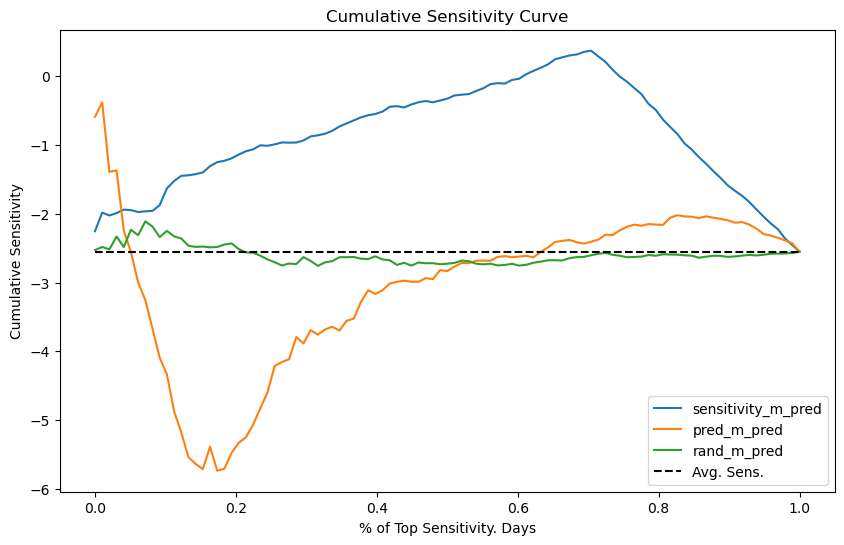

In [50]:
plt.figure(figsize=(10,6))

for m in ["sensitivity_m_pred", "pred_m_pred", "rand_m_pred"]:
    cumu_sens = cumulative_sensitivity_curve(prices_rnd_pred, m, "sales", "price", min_periods=100, steps=100)
    x = np.array(range(len(cumu_sens)))
    plt.plot(x/x.max(), cumu_sens, label=m)

plt.hlines(sensitivity(prices_rnd_pred, "sales", "price"), 0, 1, linestyles="--", color="black", label="Avg. Sens.")
plt.xlabel("% of Top Sensitivity. Days")
plt.ylabel("Cumulative Sensitivity")
plt.title("Cumulative Sensitivity Curve")
plt.legend();

Interpreting a Cumulative Sensitivity Curve can be a bit challenging, but here is how I see it. Again, it might be easier to think about the binary case. The X axis of the curve represents how many samples are we treating. Here, I've normalized the axis to be the proportion of the dataset, so .4 means we are treating 40% of the samples. The Y axis is the sensitivity we should expect at that many samples. So, if a curve has value -1 at 40%, it means that the sensitivity of the top 40% units is -1. 

Ideally, __we want the highest sensitivity for the largest  possible sample__. An ideal curve then would start high up on the Y axis and descend very slowly to the average sensitivity, representing we can treat a high percentage of units while still maintaining an above average sensitivity. 

Needless to say, none of our models gets even close to an ideal sensitivity curve. 
- The random model `rand_m` oscillates around the average sensitivity and never goes too far away from it. This means that the model can't find groups where the sensitivity is different from the average one.
- As for the predictive model `pred_m`, it appears to be reversely ordering sensitivity, because the curve starts below the average sensitivity. Not only that, it also converges to the average sensitivity pretty quickly, at around 50% of the samples. 
- Finally, the causal model `sensitivity_m` seems more interesting. It has this weird behavior at first, where the cumulative sensitivity increases away from the average, but then it reaches a point where we can treat about 75% of the units while keeping a pretty decent sensitivity of almost 0. This is probably happening because this model can identify the very low sensitivity (high price sensitivity) days. Hence, provided we don't increase prices on those days, we are allowed to do it for most of the sample (about 75%), while still having a low price sensitivity. 

In terms of model evaluation, the Cumulative Sensitivity Curve is already much better than the simple idea of sensitivity by band. Here, we managed to make preference statements about our models that were much more precise. Still, it's a complicated curve to understand. For this reason, we can do one further improvement.

## Cumulative Gain Curve

The next idea is a very simple, yet powerful improvement on top of the cumulative sensitivity. We will __multiply the cumulative sensitivity by the proportional sample size__. For example, if the cumulative sensitivity is, say -0.5 at 40%, we will end up with -0.2 (-0.5 * 0.4)  at that point. Then, we will compare this with the theoretical curve produced by a random model. This curve will actually be a straight line from 0 to the average treatment effect. Think about it this way: every point in the cumulative sensitivity of a random model is the ATE, because the model just produces random representative partitions of the data. If at each point along the (0,1) line we multiply the ATE by that point, we will end up with a straight line between zero and the ATE.

![img](./data/img/evaluate-causal-models/cumm_gain.png)

Once we have the theoretic random curve, we can use it as a benchmark and compare our other models against it. All curves will start and end at the same point. However, the better the model at ordering sensitivity, the more the curve will diverge from the random line in the points between zero and one. For example, in the image above, M2 is better than M1 because it diverges more before reaching the ATE at the end point. For those familiar with the ROC curve, you can think about Cumulative Gain as the ROC for causal models. 

Mathematically speaking, 

$$
\widehat{F(t)}_k = \hat{\beta_1}_k * \frac{k}{N} =\dfrac{\sum_i^k (t_i - \bar{t}) (y_i - \bar{y})}{\sum_i^k(t_i - \bar{t})^2} * \frac{k}{N}
$$


To implement it in code, all we have to do is add the proportional sample size normalization. 

In [76]:
def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    
    ## add (rows/size) as a normalizer. 
    return np.array([sensitivity(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])

For our ice cream data, we will get the following curves. 

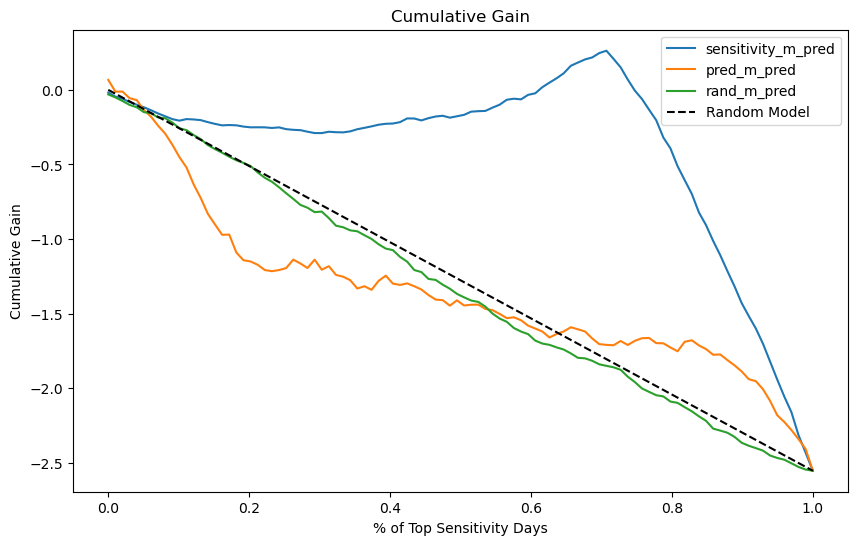

In [77]:
plt.figure(figsize=(10,6))

for m in ["sensitivity_m_pred", "pred_m_pred", "rand_m_pred"]:
    cumu_gain = cumulative_gain(prices_rnd_pred, m, "sales", "price", min_periods=50, steps=100)
    x = np.array(range(len(cumu_gain)))
    plt.plot(x/x.max(), cumu_gain, label=m)
    
plt.plot([0, 1], [0, sensitivity(prices_rnd_pred, "sales", "price")], linestyle="--", label="Random Model", color="black")

plt.xlabel("% of Top Sensitivity Days")
plt.ylabel("Cumulative Gain")
plt.title("Cumulative Gain")
plt.legend();

Now it is very clear that the causal model (`sensitivity_m`) is much better than the other two. It diverges much more from the random line than both `rand_m` and `pred_m`. Also, notice how the actual random model follows very closely the theoretical random model. The difference between both is probably just random noise. 

With that, we covered some really nice ideas on how to evaluate causal models. That alone is a huge deed. We managed to evaluate how good are models in ordering sensitivity even though we didn't have a ground truth to compare against. There is only one final thing missing, which to include a confidence interval around those measurements. After all, we are not barbarians, are we?

![img](./data/img/evaluate-causal-models/uncivilised.png)


## Taking Variance Into Account

It just feels wrong to not take variance into account when we are dealing with the sensitivity curves. Specially since all of them use linear regression theory, so adding a confidence interval around them should be fairly easy.

To achieve that, we will first create a function that returns the CI for a linear regression parameter. I'm using the formula for the simple linear regression here, but feel free to extract the CI however you want.

$$
s_{\hat\beta_1}=\sqrt{\frac{\sum_i\hat\epsilon_i^2}{(n-2)\sum_i(t_i-\bar t)^2}}
$$

In [78]:
def sensitivity_ci(df, y, t, z=1.96):
    n = df.shape[0]
    t_bar = df[t].mean()
    beta1 = sensitivity(df, y, t)
    beta0 = df[y].mean() - beta1 * t_bar
    e = df[y] - (beta0 + beta1*df[t])
    se = np.sqrt(((1/(n-2))*np.sum(e**2))/np.sum((df[t]-t_bar)**2))
    return np.array([beta1 - z*se, beta1 + z*se])

With some minor modification on our `cumulative_sensitivity_curve` function, we can output the confidence interval for the sensitivity.

In [79]:
def cumulative_sensitivity_curve_ci(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    
    # just replacing a call to `sensitivity` by a call to `sensitivity_ci`
    return np.array([sensitivity_ci(ordered_df.head(rows), y, t)  for rows in n_rows])

And finally, here is the cumulative sensitivity curve with the 95% CI for the causal model.

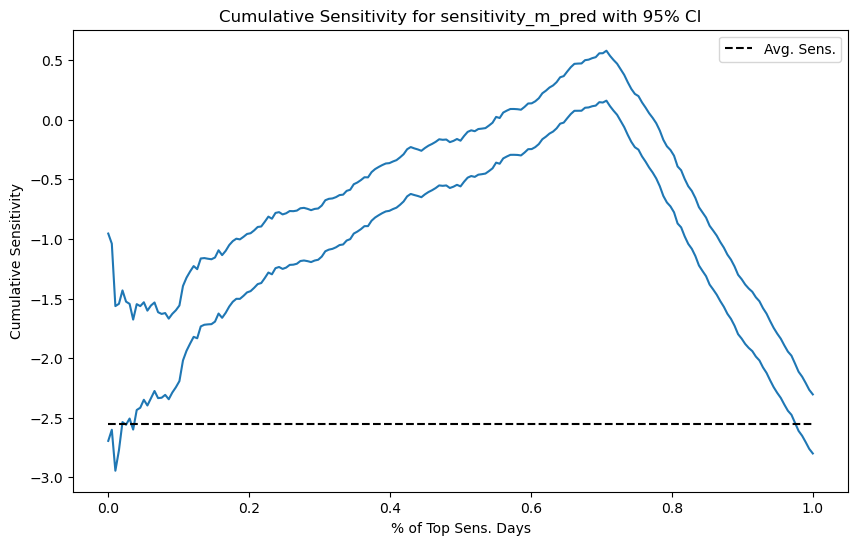

In [80]:
plt.figure(figsize=(10,6))

cumu_gain_ci = cumulative_sensitivity_curve_ci(prices_rnd_pred, "sensitivity_m_pred", "sales", "price", min_periods=50, steps=200)
x = np.array(range(len(cumu_gain_ci)))
plt.plot(x/x.max(), cumu_gain_ci, color="C0")

plt.hlines(sensitivity(prices_rnd_pred, "sales", "price"), 0, 1, linestyles="--", color="black", label="Avg. Sens.")

plt.xlabel("% of Top Sens. Days")
plt.ylabel("Cumulative Sensitivity")
plt.title("Cumulative Sensitivity for sensitivity_m_pred with 95% CI")
plt.legend();

Notice how the CI gets smaller and smaller as we accumulate more of the dataset. That's because the __sample size increases__. 

As for the Cumulative Gain curve, it is also equally simple to get the CI. Again, we just replace a call to the `sensitivity` function with a call to the `sensitivity_ci` function.

In [81]:
def cumulative_gain_ci(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    return np.array([sensitivity_ci(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])

Here is what it looks like for the causal model. Notice that now, the CI starts small, even though the sample size is smaller at the beginning of the curve. The reason is that the normalization factor $\frac{k}{N}$ shirks the ATE parameter and it's CI along with it. Since this curve should be used to compare models, this shouldn't be a problem, as the curve will apply this shirking factor equally to all the models being evaluated.

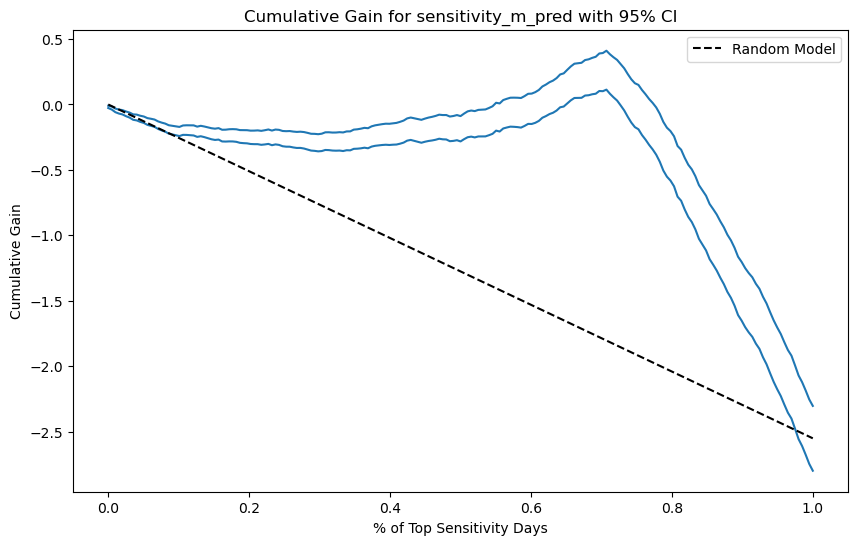

In [82]:
plt.figure(figsize=(10,6))

cumu_gain = cumulative_gain_ci(prices_rnd_pred, "sensitivity_m_pred", "sales", "price", min_periods=50, steps=200)
x = np.array(range(len(cumu_gain)))
plt.plot(x/x.max(), cumu_gain, color="C0")

plt.plot([0, 1], [0, sensitivity(prices_rnd_pred, "sales", "price")], linestyle="--", label="Random Model", color="black")

plt.xlabel("% of Top Sensitivity Days")
plt.ylabel("Cumulative Gain")
plt.title("Cumulative Gain for sensitivity_m_pred with 95% CI")
plt.legend();

## Key Ideas

Here we saw three ways to check how good a model is in terms of ordering sensitivity. We used these methods as a way to compare and decide between models that have a causal purpose. That's a huge deal. We've managed to check if a model is good at identifying groups with different sensitivities even without being able to see sensitivity!

Here, we relied heavily on random data. We trained the model on non-random data, but all the evaluation was done on a sample where the treatment has been randomized. That's because we need some way of confidently estimating sensitivity. Without random data, the simple formulas we used here wouldn't work. As we know very well by now, simple linear regression has omitted variable bias in the presence of confounding variables. 

Nonetheless, if we can get our hands on some random data, we already know how to compare random models. In the next chapter, we will address the problem of non random data, but before we go, I wanted to say some last words about model evaluation. 

Let's reiterate how important trustworthy model evaluation is. With the `cumulative gain curve`, we finally have a good way of comparing models that are used for causal inference. We can now decide which model is better for treatment personalisation. That's a major deal. Most materials you will find out there in causal inference don't give us a good way of doing model evaluation. In my opinion, that's the missing piece we need to make causal inference as popular as machine learning. With good evaluation, we can take causal inference closer to the train-test paradigm that has already been so useful for predictive models. That's a bold statement. Which means I'm careful when I say it, but until now, I haven't found any good criticism of it. If you have some, please let me know.

## References 

The things I've written here are mostly stuff from my head. I've learned them through experience. This means that they have **not** passed the academic scrutiny that good science often goes through. Instead, notice how I'm talking about things that work in practice, but I don't spend too much time explaining why that is the case. It's a sort of science from the streets, if you will. However, I am putting this up for public scrutiny, so, by all means, if you find something preposterous, open an issue and I'll address it to the best of my efforts.

I got the ideas from this chapter from a Pierre Gutierrez and Jean-Yves G'erardy's article called *Causal Inference and Uplift Modeling A review of the literature*. The authors explain the concept of a Qini curve. If you search that, you will find it's a technique used for uplift modeling, which you can think of as causal inference for when the treatment is binary. Here, I took the idea from a Qini curve and generalized it to the continuous treatment case. I think the methods presented here work for both continuous and binary cases, but then again, I've never seen them anywhere else, so keep that in mind. 

I also strongly recommend reading the article by Leo Breiman (2001) on the train-test paradigm: Statistical Modeling: The Two Cultures. It's a great resource if you want to understand what makes a statistical technique successful. 

## Contribute

Causal Inference for the Brave and True is an open-source material on causal inference, the statistics of science. It uses only free software, based in Python. Its goal is to be accessible monetarily and intellectually.
If you found this book valuable and you want to support it, please go to [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). If you are not ready to contribute financially, you can also help by fixing typos, suggesting edits or giving feedback on passages you didn't understand. Just go to the book's repository and [open an issue](https://github.com/matheusfacure/python-causality-handbook/issues). Finally, if you liked this content, please share it with others who might find it useful and give it a [star on GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).